In [2]:
import numpy as np
import csv
import sqlite3
from pathlib import Path
import rdkit
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
import pandas as pd
from plotnine import *
import math

# Database Class
Create database connections and tables with data from activity_data.csv

In [3]:
class DatabaseManager():
    def __init__(self, database_path: str):
        """
        Parameters
        ----------
        database_path: str
            Full path of existing SQLite database or one to be created automatically
        """

        # Store SQLite database path for reference
        self._database_path = database_path

        # Connect to and Create (if doesn't already exist) SQLite database
        self._conn = sqlite3.connect(database_path)

        # List of tables that need to be dropped to reset the SQLite database
        self._drop_order = ('assays', 'compounds',)


    def get_conn(self):
        """
        get_conn returns a connection to the SQLite database self._database_path

        Returns
        -------
            SQLite connection object
        """
        return self._conn
    
    def drop_all(self):
        """
        drop_all drops all tables created by this class to reset the SQLite database
        """

        # Get connection to SQLite database
        conn = self.get_conn()

        # Drop all tables in dependency order
        for table_name in self._drop_order:
            conn.execute('DROP TABLE IF EXISTS ' + table_name)


    def create(self):
        """
        create - creates all tables required by this class in the SQLite database
        """

        # Get connection to SQLite database
        conn = self.get_conn()

        # Create a table to store all COVID Moonshot assay data
        conn.execute('''
CREATE TABLE assays
(
    CID VARCHAR(20) PRIMARY KEY,
    r_avg_IC50 DECIMAL,
    f_avg_IC50 DECIMAL,
    trypsin_IC50 DECIMAL,
    acrylamide VARCHAR(5),
    chloroacetamide VARCHAR(5),
    series VARCHAR(30),
    frag_id VARCHAR(6),
    FOREIGN KEY(CID) REFERENCES compounds(CID) 
)
        ''')

        # Create a table to store all COVID Moonshot compound submissions
        conn.execute('''
CREATE TABLE compounds
(
    CID VARCHAR(20) PRIMARY KEY,
    smiles VARCHAR(250) not null,
    NumHDonors REAL,
    NumHAcceptors REAL,
    ExactMolWt REAL,
    MolLogP REAL
)
        ''')


    def populate_compounds_table(self, all_data_file: Path):
        """
        Populate the table compounds by reading out all of the unique submissions from $all_data_file and 
        adding features for Lipinski's rule of 5
        """

        compounds_list = []
        with open(all_data_file, mode = 'r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                compound_id = row["CID"]
                smiles = row["SMILES"]
                mol = rdkit.Chem.MolFromSmiles(smiles)
                NumHDonors = Descriptors.NumHDonors(mol)
                NumHAcceptors = Descriptors.NumHAcceptors(mol)
                ExactMolWt = Descriptors.ExactMolWt(mol)
                MolLogP = Descriptors.MolLogP(mol)
                comp_tuple = (compound_id, smiles, NumHDonors,
                                NumHAcceptors, ExactMolWt,
                                MolLogP)
                if comp_tuple not in compounds_list:
                    compounds_list.append(comp_tuple)

        conn = self.get_conn()
        conn.executemany('''INSERT INTO compounds (CID, SMILES, NumHDonors,
                                NumHAcceptors, ExactMolWt,
                                MolLogP) VALUES(?,?,?,?,?,?)''', compounds_list)

    def populate_assays_table(self, all_data_file: Path):
        """
        Populate the table assays by reading out all of the unique submissions from $all_data_file
        """

        assays_list = []
        with open(all_data_file, mode = 'r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                compound_id = row["CID"]
                r_avg_IC50 = row["r_avg_IC50"]
                f_avg_IC50 = row["f_avg_IC50"]
                trypsin_IC50 = row["trypsin_IC50"]
                acrylamide = row["acrylamide"]
                chloroacetamide = row["chloroacetamide"]
                series = row["series"]
                frag_id = row["frag_id"]
                assay_tuple = (compound_id,
                                r_avg_IC50,
                                f_avg_IC50,
                                trypsin_IC50,
                                acrylamide,
                                chloroacetamide,
                                series,
                                frag_id)
                if assay_tuple not in assays_list:
                    assays_list.append(assay_tuple)

        conn = self.get_conn()
        conn.executemany('INSERT INTO assays (CID, r_avg_IC50, f_avg_IC50,trypsin_IC50,acrylamide,chloroacetamide,series,frag_id) VALUES(?,?,?,?,?,?,?,?)', assays_list)

    def all_data_df(self):
        """
        Extract all compounds from the DB with assay data
        """
        conn = self.get_conn()

        cur = conn.execute('''
            SELECT c.CID, c.smiles,
            a.r_avg_IC50, a.f_avg_IC50, a.trypsin_IC50, a.acrylamide, a.chloroacetamide, a.series, a.frag_id
            FROM
            compounds c LEFT JOIN assays a
            ON
            c.CID = a.CID           
        ''')
        
        # Print the outputs to check query works as intended
        # print("All compounds:\n")
        # for row in cur:
        #     print(row)

        # Return alla compounds as pandas dataframe
        all_comps = pd.DataFrame(cur.fetchall(), columns=['CID', 'smiles', 'r_avg_IC50', 'f_avg_IC50', 'trypsin_IC50',
                                        'acrylamide', 'chloroacetamide', 'series', 'frag_id'])

        return all_comps

    def lipinski_compounds(self):
        """
        Extract all compounds compliant with the Lipinski rule of 5 from the DB
        """
        conn = self.get_conn()

        cur = conn.execute('''
            SELECT c.*,
            a.r_avg_IC50, a.f_avg_IC50, a.trypsin_IC50, a.acrylamide, a.chloroacetamide, a.series, a.frag_id
            FROM
            compounds c LEFT JOIN assays a
            ON
            c.CID = a.CID
            WHERE
            c.NumHDonors <= 5 AND c.NumHAcceptors <= 10 AND c.ExactMolWt < 500 AND c.MolLogP < 5
            
        ''')
        
        # Print the outputs to check query works as intended
        # print("Lipinski compounds:\n")
        # for row in cur:
        #     print(row)

        # Return Lipinski compounds as pandas dataframe
        lipinski_comps = pd.DataFrame(cur.fetchall(), columns=['CID', 'smiles','NumHDonors','NumHAcceptors',
                                        'ExactMolWt', 'MolLogP', 'r_avg_IC50', 'f_avg_IC50', 'trypsin_IC50',
                                        'acrylamide', 'chloroacetamide', 'series', 'frag_id'])

        return lipinski_comps


    def print_table_tops(self):
        """
        REMOVE LATER - Print the first 15 rows of both tables created to test they have been created correctly - REMOVE LATER
        """
        conn = self.get_conn()
        cur_comps = conn.execute('''
            SELECT * FROM compounds LIMIT 15
        ''')

        for row in cur_comps:
            print(row)

        print("\n")

        cur_assays = conn.execute('''
            SELECT * FROM assays LIMIT 15
        ''')

        for row in cur_assays:
            print(row)


# Call database manager methods to create tables 
Create the compound and assay tables from activity_data.csv:

In [4]:
all_data_file = Path('activity_data.csv')

manager = DatabaseManager(database_path='activity_data.db')
manager.drop_all()
manager.create()
manager.populate_compounds_table(all_data_file=all_data_file)
manager.populate_assays_table(all_data_file=all_data_file)

# print_table_tops shows first 15 rows of each table - can be used to check tables are generated correctly
manager.print_table_tops()

('MAT-POS-be048f2c-5', 'CCn1nccc1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccccc34)C2=O)C1', 0.0, 5.0, 485.161852688, 4.435300000000003)
('EDJ-MED-cc48ee33-4', 'Cc1cnn(C)c1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccccc34)C2=O)C1', 0.0, 5.0, 485.161852688, 4.260820000000003)
('EDJ-MED-cc48ee33-5', 'Cc1cc(C(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc45)C3=O)C2)n(C)n1', 0.0, 5.0, 485.16185268800007, 4.260820000000003)
('MIK-UNK-58cd43d0-1', 'O=C(Nc1cncc2c1CCCC2)[C@H]1CNS(=O)(=O)c2ccc(Cl)cc21', 2.0, 4.0, 391.07574011599996, 2.628000000000001)
('MIK-UNK-78dbf1b8-1', 'O=C(Nc1cncc2c1CCCC2)[C@@H]1CNS(=O)(=O)c2ccc(Cl)cc21', 2.0, 4.0, 391.07574011599996, 2.628000000000001)
('SAL-UNI-60119594-1', 'CC(CCC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)C(C)(C)O)C1CCC2(C)C3CC=C4C(CCC(O)C4(C)C)C3(C)C(O)CC12C', 10.0, 14.0, 800.492206984, 1.1198000000000037)
('SAL-UNI-60119594-2', 'COC(C)(C)/C=C/C[C@@H](C)[C@H]1CC[C@@]2(C)[C@@H]3[C@@H](O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)C=C4[C@@H](CC[C@H](O)C4(C)C)[C@]3(C=O)CC[C@]12C', 5.

# Extract data
Populate a dataframe of all components with assay data for which molecular descriptors can be calculated. lipinski_comps is a dataframe of components satisfying the Lipinski rule of 5 criteria.

In [5]:

all_comps = manager.all_data_df()
lipinski_comps = manager.lipinski_compounds()

manager.get_conn().commit()

all_comps.head()

,CID,smiles,r_avg_IC50,f_avg_IC50,trypsin_IC50,acrylamide,chloroacetamide,series,frag_id
0,MAT-POS-be048f2c-5,CCn1nccc1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccc...,,0.297012,,False,False,3-aminopyridine-like,
1,EDJ-MED-cc48ee33-4,Cc1cnn(C)c1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4c...,,0.682988,,False,False,3-aminopyridine-like,
2,EDJ-MED-cc48ee33-5,Cc1cc(C(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc4...,,0.463982,,False,False,3-aminopyridine-like,
3,MIK-UNK-58cd43d0-1,O=C(Nc1cncc2c1CCCC2)[C@H]1CNS(=O)(=O)c2ccc(Cl)...,,0.723365,,False,False,3-aminopyridine-like,
4,MIK-UNK-78dbf1b8-1,O=C(Nc1cncc2c1CCCC2)[C@@H]1CNS(=O)(=O)c2ccc(Cl...,,0.205139,,False,False,3-aminopyridine-like,


# Featurization
Featurize the data using all descriptors available in rdkit.descriptors. Then remove features with zero variance.

In [6]:
mol_smiles = all_comps['smiles']

all_descriptors = {d[0]: d[1] for d in Descriptors.descList}

features = {}
for i in range(len(mol_smiles)):
    mol = rdkit.Chem.MolFromSmiles(mol_smiles[i])
    features[i] = {d: all_descriptors[d](mol) for d in all_descriptors}

features = pd.DataFrame.from_dict(features).T
features.head()


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,14.277823,-0.872863,14.277823,0.027158,0.429991,485.975,461.783,485.161853,176.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.288587,-0.877395,14.288587,0.029261,0.425072,485.975,461.783,485.161853,176.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14.275766,-0.876264,14.275766,0.029763,0.425072,485.975,461.783,485.161853,176.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.921568,-3.613462,12.921568,0.003930,0.823203,391.880,373.736,391.075740,136.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.921568,-3.613462,12.921568,0.003930,0.823203,391.880,373.736,391.075740,136.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
features_cov = features.cov()
vars = pd.DataFrame(np.diagonal(features_cov), index=all_descriptors, columns=['Variance']).sort_values(by='Variance', ascending=False)

features = features.drop(vars[vars['Variance']==0].index.values, axis = 1)
features.head()


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,14.277823,-0.872863,14.277823,0.027158,0.429991,485.975,461.783,485.161853,176.0,0.271968,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.288587,-0.877395,14.288587,0.029261,0.425072,485.975,461.783,485.161853,176.0,0.272232,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14.275766,-0.876264,14.275766,0.029763,0.425072,485.975,461.783,485.161853,176.0,0.271966,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.921568,-3.613462,12.921568,0.003930,0.823203,391.880,373.736,391.075740,136.0,0.240398,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.921568,-3.613462,12.921568,0.003930,0.823203,391.880,373.736,391.075740,136.0,0.240398,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
all_comps = pd.concat([all_comps, features], axis = 1)
all_comps.head()

,CID,smiles,r_avg_IC50,f_avg_IC50,trypsin_IC50,acrylamide,chloroacetamide,series,frag_id,MaxEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,MAT-POS-be048f2c-5,CCn1nccc1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccc...,,0.297012,,False,False,3-aminopyridine-like,,14.277823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EDJ-MED-cc48ee33-4,Cc1cnn(C)c1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4c...,,0.682988,,False,False,3-aminopyridine-like,,14.288587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EDJ-MED-cc48ee33-5,Cc1cc(C(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc4...,,0.463982,,False,False,3-aminopyridine-like,,14.275766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MIK-UNK-58cd43d0-1,O=C(Nc1cncc2c1CCCC2)[C@H]1CNS(=O)(=O)c2ccc(Cl)...,,0.723365,,False,False,3-aminopyridine-like,,12.921568,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MIK-UNK-78dbf1b8-1,O=C(Nc1cncc2c1CCCC2)[C@@H]1CNS(=O)(=O)c2ccc(Cl...,,0.205139,,False,False,3-aminopyridine-like,,12.921568,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# save out the compounds
all_comps.to_pickle("pandas_dumps/featurised_compounds.pkl")

# Distribution of pIC50
Compute pIC50 values and plot distribution. f_avg_IC50 has fewer missing values, so use this as IC50 estimate and remove those with empty f_avg_IC50.
Comute -log10 of f_avg_IC50 and plot using ggplot.

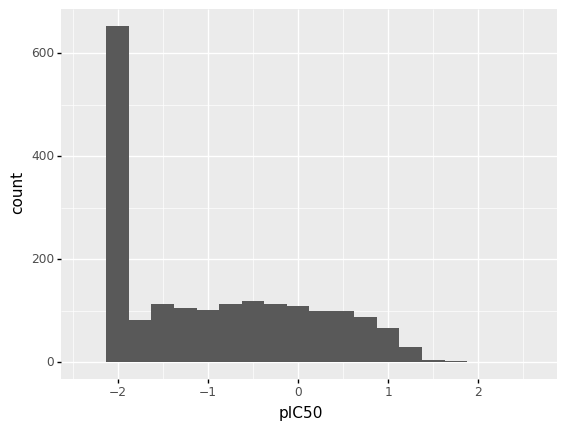

<ggplot: (8762064750521)>

In [18]:
rows_to_drop = all_comps[all_comps["f_avg_IC50"] == ""].index.values.tolist()
rows_to_drop = rows_to_drop + (all_comps[pd.to_numeric(all_comps.f_avg_IC50, errors='coerce').isnull()].index.values.tolist())
all_comps.drop(all_comps.index[rows_to_drop], inplace=True)

all_comps["pIC50"] = -np.log10(all_comps["f_avg_IC50"].astype(float))
# save out the compounds
all_comps.to_pickle("pandas_dumps/featurised_compounds.pkl")
g = ggplot(aes(x="pIC50"), data = all_comps)
g + geom_histogram(binwidth=0.25)
